In [1]:
import numpy as np
import pymc as pm
import pandas as pd
import arviz as az
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from matplotlib import pyplot as plt
import matplotlib as mpl

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


For this project, the following dataset from Kaggle was used:
https://www.kaggle.com/datasets/uciml/restaurant-data-with-consumer-ratings?select=rating_final.csv
It contains 139 users and 131 restaurants, along with 1161 relations between them in the form of ratings. Both users and restaurants contain mutiple characteristics, out of which 5 were chosen.

The sanity check is in another file and it presents the same steps as here, but with 10 users and 10 restaurants. Since the dataset is smaller, it is easier to follow the steps and check the recommendations.

In the cell bellow we read the data that we need from the csvs and preprocess it.

In [19]:
user_data = pd.read_csv("data/userprofile.csv", usecols = ["drink_level", "smoker", "personality", "activity", "interest"])
restaurant_data = pd.read_csv("data/geoplaces2.csv", usecols = ["alcohol", "smoking_area", "dress_code", "price", "area"])
restaurant_id = pd.read_csv("data/geoplaces2.csv", usecols = ["placeID"])
restaurant_name = pd.read_csv("data/geoplaces2.csv", usecols = ["name"])
ratings_data = pd.read_csv("data/rating_final.csv", usecols = ["userID", "placeID", "rating"])

restaurants = np.array(restaurant_data.values.tolist())
ids = np.array(restaurant_id.values.tolist()).flatten()
names = np.array(restaurant_name.values.tolist()).flatten()
users = np.array(user_data.values.tolist())
ratings = ratings_data.values.tolist()

no_users = len(users)
no_rest = len(restaurants)
no_ratings = len(ratings)
no_latent_factors = 5

unique_users = np.unique(users.flatten())
unique_rest = np.unique(restaurants.flatten())

users_features = []
for user in users:
    item_list = []
    for item in user:
        for index in range(len(unique_users)):
            if item == unique_users[index]:
                item_list.append(index)
    users_features.append(item_list)

rest_features = []
for restaurant in restaurants:
    item_list = []
    for item in restaurant:
        for index in range(len(unique_rest)):
            if item == unique_rest[index]:
                item_list.append(index)
    rest_features.append(item_list)

features = [users_features, rest_features]

matrix = [[0 for j in range(no_rest)] for i in range(no_users)]
for rating in ratings:
    for index in range(no_rest):
        if rating[1] == ids[index]:
            matrix[int(rating[0][-1]) - 1][index] = rating[2]

print(no_ratings)

1161


The matrix created above and displayed below represents the User-Item Interactions matrix described in the project PDF. The matrix turned out to have a lot more zeros than anticipated, due to the original data in the Kaggle files. 

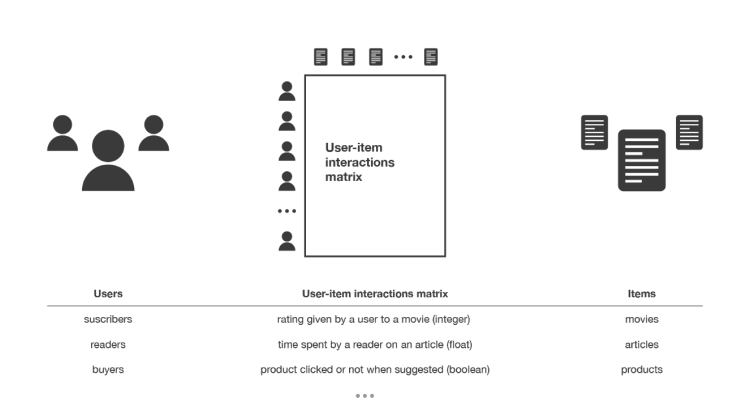

In [3]:
for i in range(len(matrix)):
    for j in range(len(matrix[0])):
        print(matrix[i][j], end=" ")
    print()
        
print(features)

2 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 2 0 1 2 1 2 2 2 0 2 2 0 1 0 2 0 0 0 2 2 0 0 2 2 2 0 1 1 1 0 2 0 1 2 2 0 0 2 1 0 2 0 0 0 2 0 2 1 2 2 2 0 1 2 2 0 0 0 0 0 0 0 1 2 1 0 2 2 1 0 2 1 0 0 0 0 1 2 0 0 1 2 2 1 1 0 0 0 0 1 0 0 2 0 1 0 0 0 0 1 1 2 0 2 2 0 0 0 0 2 0 1 2 1 
0 2 1 0 0 0 0 0 0 0 0 0 2 0 0 2 2 0 1 0 1 2 2 1 0 0 2 0 0 2 0 0 2 0 2 2 2 1 1 0 2 0 0 0 2 1 0 1 1 2 0 0 2 0 1 0 0 0 2 0 2 0 1 1 1 1 0 0 2 1 0 1 0 1 0 0 0 0 0 1 1 2 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 2 0 0 2 0 0 0 0 2 0 0 0 0 2 0 2 1 0 0 2 2 0 0 2 1 0 0 0 2 0 0 0 0 
2 2 0 1 1 0 1 2 1 0 0 0 0 1 0 0 0 2 0 0 0 0 1 0 2 2 0 0 2 0 0 1 2 0 2 2 2 2 1 0 0 1 2 0 0 0 0 2 2 2 0 0 0 2 1 0 0 2 0 0 1 2 2 0 2 0 0 1 0 0 0 0 1 1 2 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 0 2 2 2 2 1 2 0 1 0 0 2 2 0 2 2 1 0 0 0 2 0 1 0 
0 0 2 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 2 0 1 2 0 0 0 1 2 0 2 0 0 0 0 0 2 2 0 1 0 2 2 0 2 0 0 0 2 2 0 0 1 0 2 0 2 0 0 2 0 2 2 1 0 2 0 2 0 2 0 2 0 0 0 0 1 0 0 1 1 0 0 0 0 0 2 0 0 0 0 0 1 2 0 2 0 0 0 1 0 2 0 1 1 0 0 1 0 2 2

The model is created in the cell below. It follows the steps described in the "Scalable Recommendation with Poisson Factorization" paper that was given as a reference. The Poisson distribution observes the initial matrix.
We use the Metropolis step, which takes into consideration the first four distributions, and trace the steps.

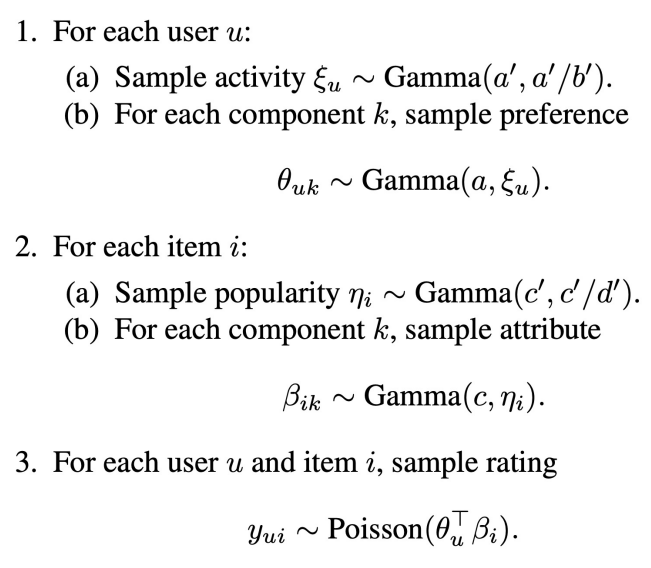

In [4]:
with pm.Model() as HPF:
    activity = pm.Gamma("activity", alpha=0.3, beta=0.3, shape=no_users)
    popularity = pm.Gamma("popularity", alpha=0.3, beta=0.3, shape=no_rest)

    preference = pm.Gamma("preference", alpha=0.3, beta=activity[:, None], shape=(no_users, no_latent_factors))
    attribute = pm.Gamma("attribute", alpha=0.3, beta=popularity[:, None], shape=(no_rest, no_latent_factors))

    rating = pm.Poisson("rating", mu=pm.math.dot(preference, attribute.T), observed = matrix)

    step = pm.Metropolis()
    trace = pm.sample(10, step=step, tune=10, cores=1)

Only 10 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [activity]
>Metropolis: [popularity]
>Metropolis: [preference]
>Metropolis: [attribute]


Sampling 1 chain for 10 tune and 10 draw iterations (10 + 10 draws total) took 42434 seconds.
The number of samples is too small to check convergence reliably.


Unfortunately, I could only let it run for one chain out of the two, and couldn't use a bigger amount of samples, since the computation time was too big. 

In [6]:
pm.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 10), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
activity[0],0.167,0.071,0.074,0.292,0.026,0.019,9.0,10.0,NaN
activity[1],0.163,0.091,0.123,0.419,0.029,0.021,9.0,4.0,NaN
activity[2],0.166,0.066,0.101,0.272,0.038,0.030,3.0,10.0,NaN
activity[3],0.138,0.041,0.084,0.212,0.013,0.010,10.0,10.0,NaN
activity[4],0.092,0.094,0.024,0.353,0.030,0.022,9.0,10.0,NaN
...,...,...,...,...,...,...,...,...,...
"attribute[129, 0]",0.036,0.011,0.015,0.047,0.005,0.004,3.0,10.0,NaN
"attribute[129, 1]",0.032,0.023,0.010,0.062,0.011,0.008,4.0,10.0,NaN
"attribute[129, 2]",0.004,0.004,0.001,0.011,0.002,0.001,5.0,10.0,NaN
"attribute[129, 3]",0.009,0.006,0.002,0.019,0.002,0.002,10.0,10.0,NaN


We extract the latent vectors  and plot the weight of each feature in the latent vectors for each user, for a visualisation of importance.

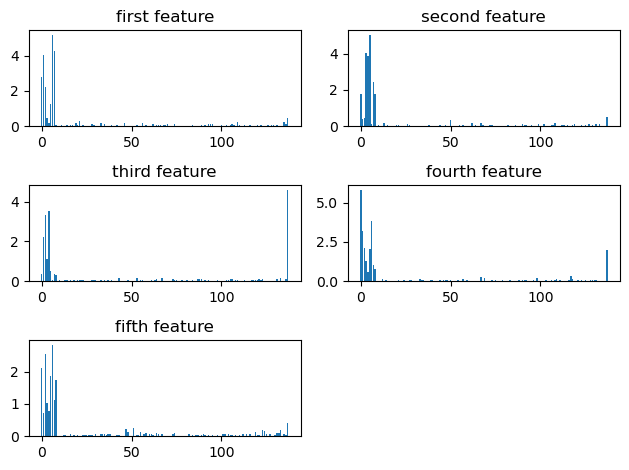

In [9]:
users_samples = np.mean(trace["posterior"]['preference'][0][:], axis=0)
rest_samples = np.mean(trace["posterior"]['attribute'][0][:], axis=0)

first_feature = list(zip(*users_samples))[0]
second_feature = list(zip(*users_samples))[1]
third_feature = list(zip(*users_samples))[2]
fourth_feature = list(zip(*users_samples))[3]
fifth_feature = list(zip(*users_samples))[4]

figure, axis = plt.subplots(3, 2)

axis[0, 0].bar(np.arange(138), first_feature)
axis[0, 0].set_title("first feature")

axis[0, 1].bar(np.arange(138), second_feature)
axis[0, 1].set_title("second feature")

axis[1, 0].bar(np.arange(138), third_feature)
axis[1, 0].set_title("third feature")

axis[1, 1].bar(np.arange(138), fourth_feature)
axis[1, 1].set_title("fourth feature")

axis[2, 0].bar(np.arange(138), fifth_feature)
axis[2, 0].set_title("fifth feature")

axis[2, 1].axis('off')
figure.tight_layout()
plt.show()

With the previous latent vectors we calculate the predicted ratings. The comparison between the true ratings and the predicted ones is presented below, along with the Mean Squared Error.

Mean Squared Error: 0.039005678533647184


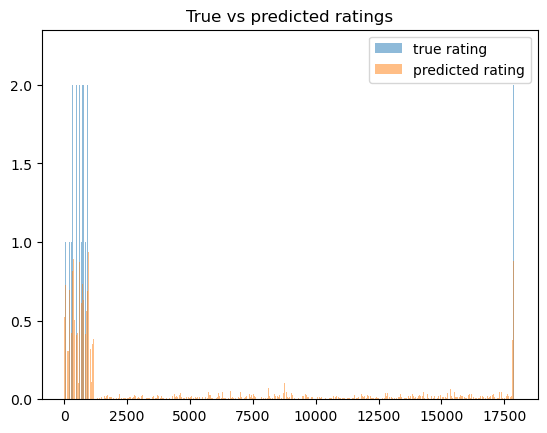

In [18]:
predicted_ratings = np.dot(users_samples, rest_samples.T)

mse = np.mean((matrix - predicted_ratings)**2)
print(f"Mean Squared Error: {mse}")

matrix_count = np.array(matrix).flatten()
ratings_count = np.array(predicted_ratings).flatten()

plt.bar(np.arange(len(matrix_count)), matrix_count, alpha=0.5, label = "true rating")
plt.bar(np.arange(len(matrix_count)), ratings_count, alpha=0.5, label = "predicted rating")
plt.legend()
plt.title("True vs predicted ratings")
figure.tight_layout()
plt.show()

Recommendation.

For a chosen user, list the top most liked restaurants and list the top recommendations, taken from the predicted data.

Since you liked:
El Herradero Restaurante and Bar
Restaurant Las Mananitas
Cabana Huasteca

You should try the following restaurants:
la Cantina
Restaurante Tiberius
El cotorreo


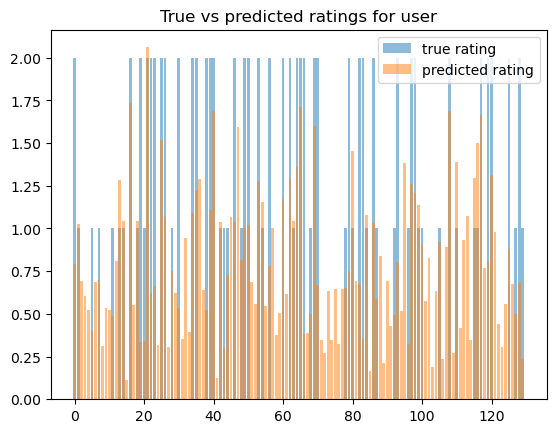

In [20]:
user = 2

recs = []
for index in range(no_rest):
    recs.append((predicted_ratings[user][index], index))

sorted_recs = sorted(recs, reverse = True)

print("Since you liked:")
no_recs = 3
for index in range(no_rest):
    if no_recs > 0:
        if matrix[user][sorted_recs[index][1]] != 0:
            print(names[sorted_recs[index][1]])
            no_recs -=1

print()
print("You should try the following restaurants:")
no_recs = 3
for index in range(no_rest):
    if no_recs > 0:
        if matrix[user][sorted_recs[index][1]] == 0:
            print(names[sorted_recs[index][1]])
            no_recs -=1

matrix_count = np.array(matrix).flatten()[:no_rest]
ratings_count = np.array(predicted_ratings).flatten()[:no_rest]

plt.bar(np.arange(len(matrix_count)), matrix_count, alpha=0.5, label = "true rating")
plt.bar(np.arange(len(matrix_count)), ratings_count, alpha=0.5, label = "predicted rating")
plt.legend()
plt.title("True vs predicted ratings for user")
figure.tight_layout()
plt.show()

In [16]:
train = pm.sample_posterior_predictive(trace, HPF)

Sampling: [rating]


Accuracy:

In [17]:
print(np.mean(matrix == train['posterior_predictive']) * 100)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    rating   float64 94.94


array([[<Axes: title={'center': 'activity'}>,
        <Axes: title={'center': 'activity'}>],
       [<Axes: title={'center': 'popularity'}>,
        <Axes: title={'center': 'popularity'}>],
       [<Axes: title={'center': 'preference'}>,
        <Axes: title={'center': 'preference'}>],
       [<Axes: title={'center': 'attribute'}>,
        <Axes: title={'center': 'attribute'}>]], dtype=object)

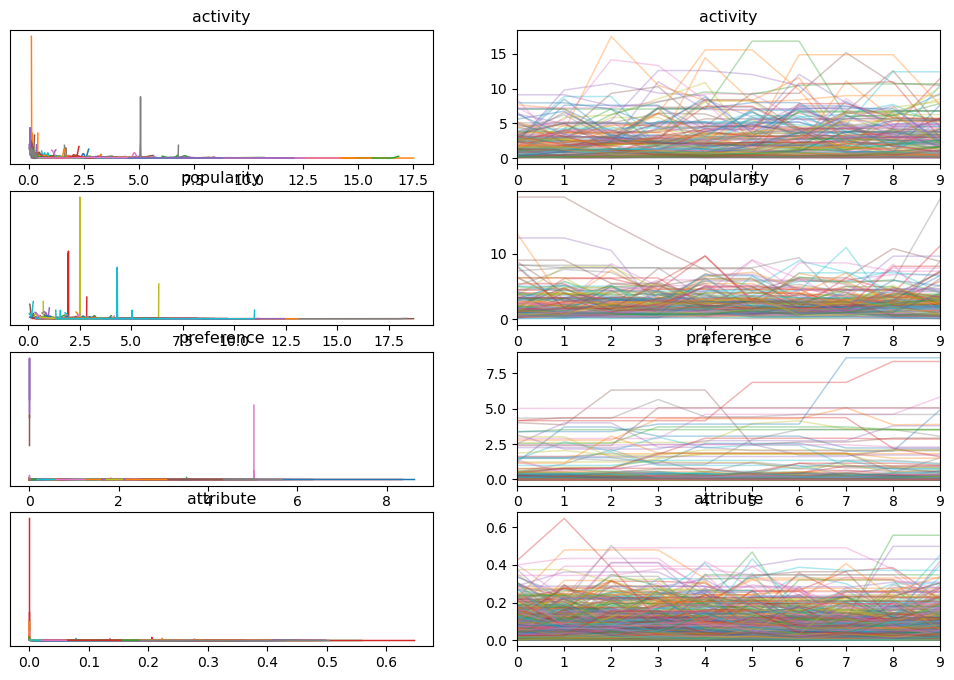

In [15]:
az.plot_trace(trace.posterior)